# Primary sector - Hand in

### This notebook will give an overview on the datasets and algorithms that will be used for the first hand-in regarding the primary sector in the lecture Industrial Applications of AI by Niklas Sabel (Matr. no. 1599748)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import ipyparallel as ipp
import os
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from scipy.stats import boxcox
import warnings
from pmdarima import auto_arima

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import StandardScaler

from platform import python_version
if python_version() < '3.8':
    import pickle5 as pickle
else:
    import pickle

## 1. Import data and check for stationarity

In [3]:
path = '../../src/data/Abgabe_1'

In [4]:
#import data
df_turbine = pd.read_csv(os.path.join(path, 'Turbine_Data.csv')).rename(columns={'Unnamed: 0':'timestamp'}).dropna(subset=['ActivePower'])
df_turbine
y = df_turbine['ActivePower'].values
x = df_turbine['timestamp'].values

In [ ]:
nrows=2
ncols=2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8))

# plot data with different orders of differencing and tranformations
# make sure to choose appropriate settings for KPSS and ADF tests
for n_plot, (x_plot, y_plot, title, reg_adf, reg_kpss) in enumerate([(x, y, '$y_t$', 'ctt', 'ct'),
                                                              (x[1:], np.diff(y, 1), '$(1-B)y_t$', 'c', 'c')]):
    ax = axes[n_plot//2, n_plot%2]
    ax.plot(x_plot, y_plot, color='b')
    ax.set_xticks(x_plot[::20])
    title += '\n ADF-test: {:.4f}.'.format(adfuller(y_plot, regression=reg_adf)[1])
    title += '\n KPSS-test: {:.4f}.'.format(kpss(y_plot, regression=reg_kpss, nlags='auto')[1])
    ax.set_title(title)
    if n_plot//2==nrows-1:
        ax.set_xlabel('Year-Month')
    if n_plot%2==0:
        ax.set_ylabel('Active energy')
fig.suptitle('Energy Production')
fig.tight_layout()

C:\Users\Nikla\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1998: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\Nikla\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2002: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [8]:
df_turbine

,timestamp,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
144,2018-01-01 00:00:00+00:00,-5.357727,23.148729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.000000,-9.960830,NaN,NaN,G01,8.000000,2.279088
145,2018-01-01 00:10:00+00:00,-5.822360,23.039754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,300.428571,-9.628441,NaN,NaN,G01,300.428571,2.339343
146,2018-01-01 00:20:00+00:00,-5.279409,22.948703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,340.000000,-9.491235,NaN,NaN,G01,340.000000,2.455610
147,2018-01-01 00:30:00+00:00,-4.648054,22.966851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,345.000000,-9.856136,NaN,NaN,G01,345.000000,2.026754
148,2018-01-01 00:40:00+00:00,-4.684632,22.936520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,345.000000,-9.745593,NaN,NaN,G01,345.000000,1.831420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118219,2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,...,58.148777,39.008931,36.476562,178.000000,13.775785,9.234004,2.0,G01,178.000000,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,...,57.550367,39.006759,36.328125,178.000000,8.088928,9.229370,2.0,G01,178.000000,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,...,57.099335,39.003815,36.131944,178.000000,4.355978,9.236802,2.0,G01,178.000000,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,...,56.847239,39.003815,36.007805,190.000000,12.018077,9.237374,2.0,G01,190.000000,3.284468


In [5]:
df_turbine.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,94750.000000,93431.000000,62011.000000,41941.000000,41857.000000,41857.000000,61665.0,62028.000000,62051.000000,61936.000000,62049.000000,62056.000000,61890.000000,61991.000000,72167.000000,94692.000000,61803.000000,6.265600e+04,72167.000000,94436.000000
mean,619.109805,28.785526,43.131021,9.658458,10.033684,10.033684,0.0,64.433727,57.606880,1103.378711,72.522172,71.885960,37.015963,39.631846,196.272116,88.171069,9.916779,2.269466e+03,196.272116,5.878983
std,611.275373,4.367719,5.133784,20.484572,20.274784,20.274784,0.0,9.935507,6.231958,527.047478,22.579309,22.600144,4.819782,5.428429,88.283702,116.600867,4.712238,3.593235e+05,88.283702,2.616114
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,79.642258,25.641101,39.869198,-0.940285,-0.433431,-0.433431,0.0,57.960483,53.966300,1029.817934,55.532226,54.796605,33.985607,35.847222,145.000000,-0.432636,9.231163,2.000000e+00,145.000000,3.823222
50%,402.654893,28.351504,42.946024,0.389616,0.885300,0.885300,0.0,64.889641,57.214212,1125.759949,65.838838,65.058954,37.003815,39.500759,182.000000,35.969835,10.109651,2.000000e+00,182.000000,5.560295
75%,1074.591780,31.674831,47.025745,8.044040,8.463580,8.463580,0.0,71.131715,61.317045,1516.029889,85.930105,85.364570,40.011990,43.349953,271.000000,147.422339,13.604698,2.000000e+00,271.000000,7.508195
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,0.0,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


In [6]:
df_turbine['WTG'].unique()

array(['G01'], dtype=object)

C:\Users\Nikla\AppData\Local\Temp/ipykernel_23660/3493654454.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


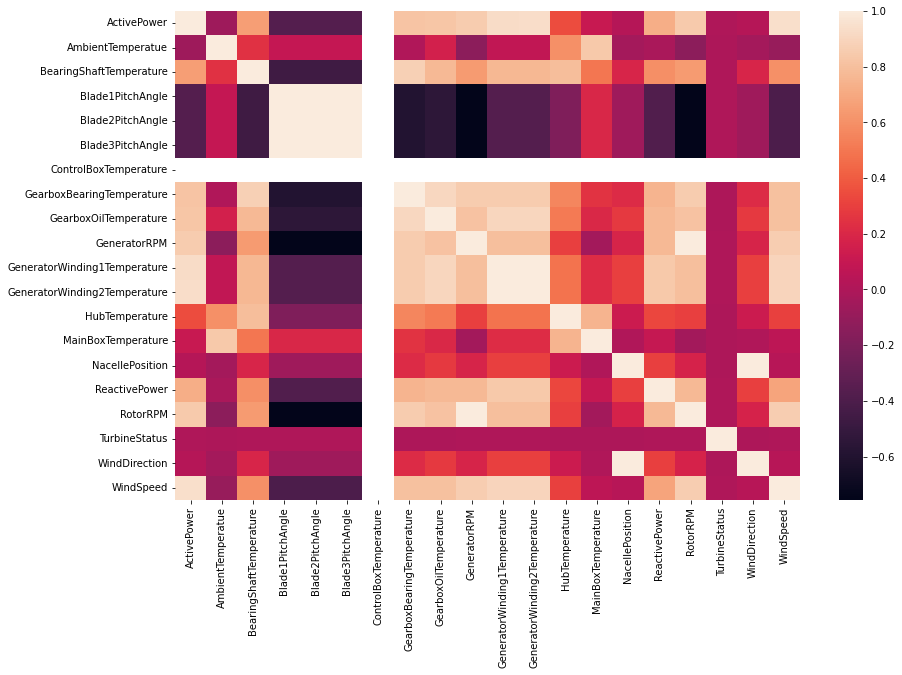

In [7]:
# investigate correlation heatmap
corrMatrix=df_turbine.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [11]:
#import data
df_wind = pd.read_csv(os.path.join(path, 'germany-wind-energy.csv'))
df_wind

,utc_timestamp,wind_generation_actual,wind_capacity,temperature
0,2017-01-01 00:00:00+00:00,291760.0,37149.130,-2.117
1,2017-01-02 00:00:00+00:00,295097.0,37152.125,-1.154
2,2017-01-03 00:00:00+00:00,666170.0,37155.208,-0.239
3,2017-01-04 00:00:00+00:00,686581.0,37160.125,0.620
4,2017-01-05 00:00:00+00:00,261759.0,37163.542,-3.908
...,...,...,...,...
1089,2019-12-26 00:00:00+00:00,132739.0,50424.125,2.790
1090,2019-12-27 00:00:00+00:00,146590.0,50427.000,1.327
1091,2019-12-28 00:00:00+00:00,159126.0,50427.292,-1.441
1092,2019-12-29 00:00:00+00:00,349839.0,50434.750,-1.314


In [14]:
#import data
df_all = pd.read_csv(os.path.join(path, 'all_energy_statistics.csv'))
df_all

,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,Austria,Additives and Oxygenates - Exports,1996,"Metric tons, thousand",5.0,NaN,additives_and_oxygenates
1,Austria,Additives and Oxygenates - Exports,1995,"Metric tons, thousand",17.0,NaN,additives_and_oxygenates
2,Belgium,Additives and Oxygenates - Exports,2014,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
3,Belgium,Additives and Oxygenates - Exports,2013,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
4,Belgium,Additives and Oxygenates - Exports,2012,"Metric tons, thousand",35.0,NaN,additives_and_oxygenates
...,...,...,...,...,...,...,...
1189477,Viet Nam,Electricity - total wind production,2012,"Kilowatt-hours, million",92.0,1.0,wind_electricity
1189478,Viet Nam,Electricity - total wind production,2011,"Kilowatt-hours, million",87.0,NaN,wind_electricity
1189479,Viet Nam,Electricity - total wind production,2010,"Kilowatt-hours, million",50.0,NaN,wind_electricity
1189480,Viet Nam,Electricity - total wind production,2009,"Kilowatt-hours, million",10.0,NaN,wind_electricity
